In [1]:
import pandas as pd 
from datetime import datetime
import Accuracy_calculate as accuracy_calc
from dateutil.relativedelta import relativedelta
import query_traffic_elastic as elastic_trafic
import model_cuantiles as mod_cuant
import matplotlib.pyplot as plt
from datetime import date
import statsmodels.formula.api as smf
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from datetime import timedelta, date
from pylab import rcParams
import math


C:\Users\Alejandro\anaconda3\lib\site-packages\elasticsearch\connection\http_urllib3.py:189: UserWarning: Connecting to https://traful-apielastic.wh.telefonica:443 using SSL with verify_certs=False is insecure.
  % self.host
C:\Users\Alejandro\anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'traful-apielastic.wh.telefonica'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


Connected {'name': 'elasticsearch-master-0', 'cluster_name': 'elasticsearch', 'cluster_uuid': 'umvfPipzQXKC3Egj5WHbyA', 'version': {'number': '7.3.0', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': 'de777fa', 'build_date': '2019-07-24T18:30:11.767338Z', 'build_snapshot': False, 'lucene_version': '8.1.0', 'minimum_wire_compatibility_version': '6.8.0', 'minimum_index_compatibility_version': '6.0.0-beta1'}, 'tagline': 'You Know, for Search'}


In [2]:
def pipe_model_forecast(df_train,bw,key):
        #Obtener el sesgo de los datos de entrenamiento 
        sesgo=mod_cuant.quartileSkewness ( serie=df_train)
        sesgo_median=sesgo.dropna().median()
        umbral_list = [sesgo_median for i in range(sesgo.index.shape[0])]
        plt.figure(figsize=(15, 5))
        plt.plot( sesgo.index, sesgo.values, markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2,label='sesgo')
        plt.plot( sesgo.index, umbral_list, markerfacecolor='blue', markersize=12, color='red', linewidth=2,label='median_sesgo')
        
        #Call to the model to return the predictiond and the timestamp asociate to model overcomes banwith 
        fechaSupera, predicciones = mod_cuant.regresionesPercetiles(df_train,[0.95,0.9,0.75,0.5,0.25],2,14,.8)
        #Interpolate quantil 75
        predicciones["interpolate_75"] = predicciones[['0.5','0.25']].apply(lambda row: (2*row['0.5']-(row['0.25']*(sesgo_median+1)))/(1-sesgo_median), axis=1)
        
        predicciones["iqr"]=predicciones[['interpolate_75','0.25']].apply(lambda row: (row['interpolate_75']-(row['0.25'])), axis=1)
        #predicciones["uper_bound"]=predicciones[['0.75','iqr']].loc[fechas.tail(1).index[0]:].apply(lambda row: (row['0.75']+(1.5*row['iqr'])), axis=1)
        predicciones["inter_uper_bound"]=predicciones[['interpolate_75','iqr']].apply(lambda row: (row['interpolate_75']+(1.5*row['iqr'])), axis=1)
        predicciones["inter_lower_bound"]=predicciones[['0.25','iqr']].apply(lambda row: (row['0.25']-(1.5*row['iqr'])), axis=1)
        predicciones["dif_btw_bw"]=predicciones[["inter_uper_bound"]].apply(lambda row: (int(bw)-(row['inter_uper_bound'])), axis=1)
        plt.figure(figsize=(15, 5))
        plt.plot( df_train.index, df_train.values, 'o', alpha=.1, zorder=0,label='Data')
        plt.plot( predicciones.index[0:-1], predicciones["0.75"][0:-1].values, markerfacecolor='blue', markersize=12, color='gold', linewidth=2,label='percetin 0.75')
        plt.plot( predicciones.index[0:-1], predicciones["interpolate_75"][0:-1].values, markerfacecolor='blue', markersize=12, color='red', linewidth=2,label='interpolate_75')
        plt.plot( predicciones.index[0:-1], predicciones["inter_uper_bound"][0:-1].values, markerfacecolor='blue', markersize=12, color='green', linewidth=2,label='inter_upper_bound')
        plt.plot( predicciones.index[0:-1], predicciones["inter_lower_bound"][0:-1].values, markerfacecolor='blue', markersize=12, color='green', linewidth=2,label='inter_lower_bound')
        plt.plot( predicciones.index[0:-1], predicciones["0.95"][0:-1].values, markerfacecolor='blue', markersize=12, color='red', linewidth=2,label='0.95')
        plt.plot( predicciones.index[0:-1], predicciones["0.5"][0:-1].values, markerfacecolor='blue', markersize=12, color='brown', linewidth=2,label='median')
        plt.plot( predicciones.index[0:-1], predicciones["0.25"][0:-1].values, markerfacecolor='blue', markersize=12, color='brown', linewidth=2,label='0.25')
        plt.plot( predicciones.index[0:-1], [int(bw) for i in range(predicciones.index[0:-1].shape[0])], markerfacecolor='blue', markersize=12, color='purple', linewidth=2,label='BW')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


In [3]:
        
def pytime_elasticTime(time):
    now = str(time).replace(" ","T")+"Z"
    return now
#A partir de los meses introducidos te devuelve la fecha de hoy y la fecha de los meses trascurrido
def timestamp_elasticsearch_now_n_now(meses):
    now=datetime.now()
    befor_now=now-relativedelta(months=meses)
    return pytime_elasticTime(now),pytime_elasticTime(befor_now)

def timestamp_elasticsearch_timestap_n_month(timestamp,meses):
    now=date.fromisoformat(timestamp)
    befor_now=now-relativedelta(months=meses)
    return pytime_elasticTime(now),pytime_elasticTime(befor_now)


In [4]:

#calculamos la fecha de hoy y la fecha para los meses anteriores añadida now=now,befor_now=now-meses
#elk_timestamp=timestamp_elasticsearch_now_n_now(2)
elk_timestamp=timestamp_elasticsearch_timestap_n_month("2020-06-01",6)
#Query to elasticsearch to from the dataset
#request trafic for sabm
reque_trafic=elastic_trafic.request_trafic_data(elk_timestamp[1].replace("Z", ""),elk_timestamp[0].replace("Z", ""),"sabm-col-baq-mw-m-386781_GigabitEthernet0/0.1100")
#reque_trafic=elastic_trafic.request_trafic_data(elk_timestamp[1].replace("Z", ""),elk_timestamp[0].replace("Z", ""),"cmex-mex-occrtriw01_GigabitEthernet0/0/0")
#reque_trafic=elastic_trafic.request_trafic_data(elk_timestamp[1].replace("Z", ""),elk_timestamp[0].replace("Z", ""),"bbva-ven-ccs-mp-m-035864_GigabitEthernet0/1")
#reque_trafic=elastic_trafic.request_trafic_data(elk_timestamp[1].replace("Z", ""),elk_timestamp[0].replace("Z", ""),"bbva-col-bog-mw-2-1004210_TenGigabitEthernet0/1/0.112")
#reque_trafic=elastic_trafic.request_trafic_data(elk_timestamp[1].replace("Z", ""),elk_timestamp[0].replace("Z", ""),'bbva-col-bog-mw-2-1004210_TenGigabitEthernet0/1/0.101')

#dataset trafic 
df_traffic=elastic_trafic.trafic_request_to_df(reque_trafic)
#Clean dataset to 
df_traffic.set_index(pd.DatetimeIndex(df_traffic['data_time']),inplace=True)
df_train=df_traffic[["Inbps","Outbps"]].astype("int64")


C:\Users\Alejandro\anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'traful-apielastic.wh.telefonica'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
C:\Users\Alejandro\anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'traful-apielastic.wh.telefonica'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
C:\Users\Alejandro\anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'traful-apielastic.wh.telefonica'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnin

C:\Users\Alejandro\anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'traful-apielastic.wh.telefonica'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
C:\Users\Alejandro\anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'traful-apielastic.wh.telefonica'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
C:\Users\Alejandro\anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'traful-apielastic.wh.telefonica'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnin

In [49]:
df_traffic

,timestamp,Outbps,Inbps,InBandwidth,data_time,OutBandwidth
data_time,,,,,,
2020-03-01 00:03:22,20200301000322,491201,4499095,26402000,2020-03-01 00:03:22,26402000
2020-03-01 00:07:25,20200301000725,489876,4340957,26402000,2020-03-01 00:07:25,26402000
2020-03-01 00:13:51,20200301001351,686771,4101484,26402000,2020-03-01 00:13:51,26402000
2020-03-01 00:16:04,20200301001604,505557,3491359,26402000,2020-03-01 00:16:04,26402000
2020-03-01 00:17:54,20200301001754,505557,3491359,26402000,2020-03-01 00:17:54,26402000
...,...,...,...,...,...,...
2020-06-01 23:37:40,20200601233740,620624,3432570,26402000,2020-06-01 23:37:40,26402000
2020-06-01 23:43:34,20200601234334,610600,1971448,26402000,2020-06-01 23:43:34,26402000
2020-06-01 23:47:38,20200601234738,590229,2037351,26402000,2020-06-01 23:47:38,26402000


In [5]:
def quantile_df(df,quantile,key):
    return df.resample('1h').apply(lambda x: x.quantile(quantile))
#Sesgo de los cuantiles 
def quartileSkewness (serie,key,UB=0.75,M=0.5,LB=0.25):
    ub=quantile_df(serie,UB,key).dropna()
    m=quantile_df(serie,M,key).dropna()
    lb=quantile_df(serie,LB,key).dropna()
    C = (ub+lb-2*m)/(ub-lb)
    #C = (lb-(ub-lb))/(14*0.8)
    #C = np.median(C)
    return C.dropna()


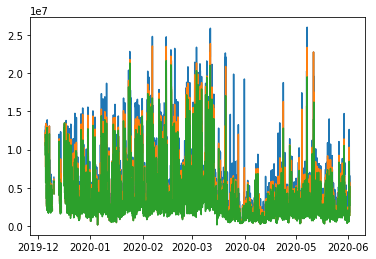

In [6]:


plt.plot(df_train[["Inbps"]].resample('1h').apply(lambda x: x.quantile(0.75)))
plt.plot(df_train[["Inbps"]].resample('1h').apply(lambda x: x.quantile(0.5)))
plt.plot(df_train[["Inbps"]].resample('1h').apply(lambda x: x.quantile(0.25)))

C:\Users\Alejandro\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
C:\Users\Alejandro\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
C:\Users\Alejandro\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
C:\Users\Alejandro\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
C:\Users\Alejandro\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached."

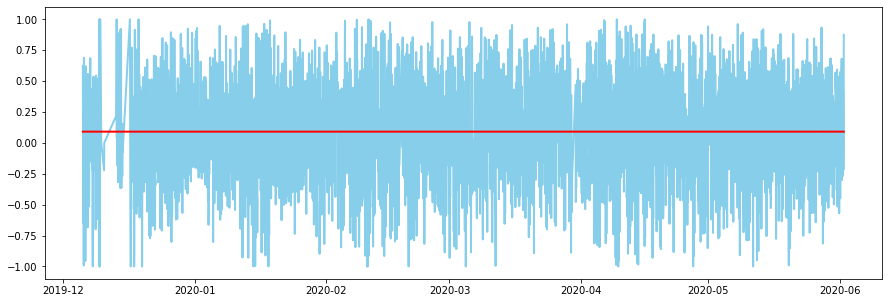

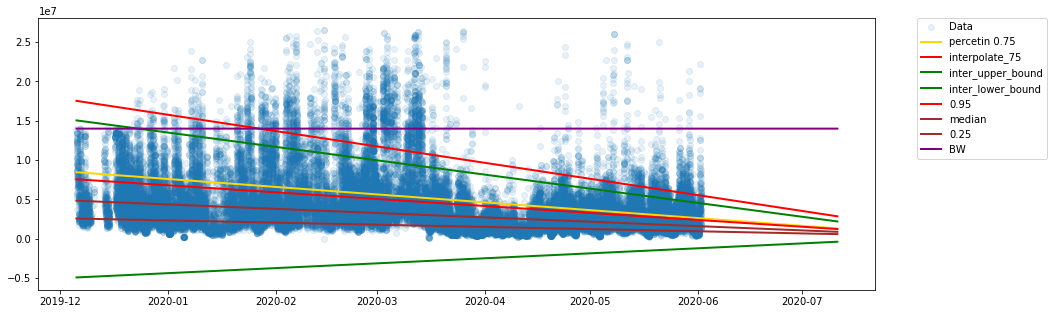

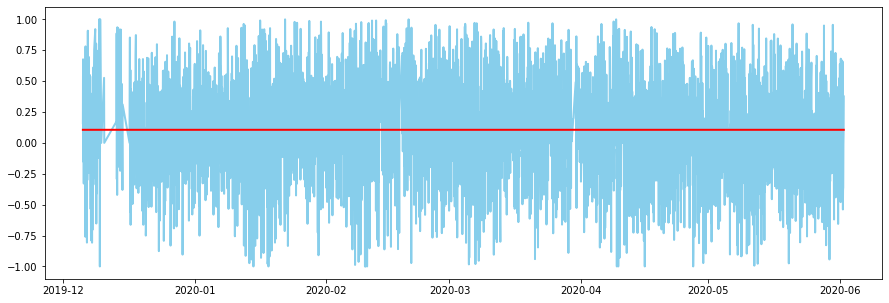

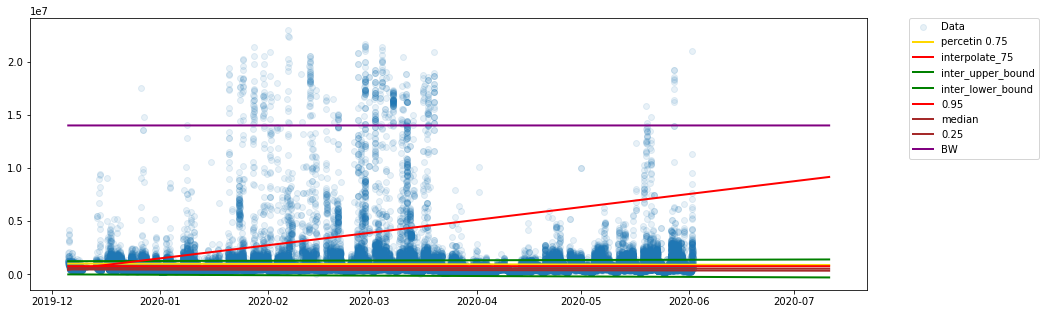

In [7]:

pipe_model_forecast(df_train[["Inbps"]],df_traffic["InBandwidth"][0],"Inbps")
pipe_model_forecast(df_train[["Outbps"]],df_traffic["OutBandwidth"][0],"Outbps")


In [8]:

def regresionesPercetiles (serie,cuantiles,meses,caudalM,porcentaje,tipoFun='lineal'): 
    #Indices y datos a usar en el modelo
    a= serie.shape[0]
    index = np.arange(1,a+1)
    #Eje x no puede ser timestamp, por lo que se genera uno auxiliar
    x = np.reshape(index, (a,1))
    #El eje y son los valores de la serie con los datos del tráfico
    y = serie.iloc[:,[0]].values[:,0]
    #Guardamos los nuevos datos para el modelo 
    data = {'x': x , 'y': y}    
    #Multiplicamos el numero de meses por los puntos en un dia y los dias en un mes
    a=a+meses*288*30
    #Valores para la predicción
    z=np.arange(1,a)
    #Creamos una lista de fechas desde la primera de la serie (entendiendo que es la posición 0 del index) hasta la ultima
    #formada por el numero de valores de la serie mas los puntos a predecir 
    date_list = [serie.index[0] + timedelta(minutes=5*x) for x in range(0, a)]
    fechas=pd.to_datetime(date_list)
    
    #Definicion del modelo
    if tipoFun == 'log':
        mod = smf.quantreg('y ~ I(np.log(x))', data)
    else: 
        mod = smf.quantreg('y ~ x', data)
    #Entrenamos el modelo con cada uno de los cuantiles
    res_all = [mod.fit(q=q) for q in cuantiles]

    #Dataframe con los datos a devolver
    fechaSupera=pd.DataFrame({'cuantiles': [] , 'fechas': []})
    valoresq=[]
    valoresf=[]
    #DataFrame con las fechas cuantil y valores
    predicciones= pd.DataFrame({'fechas': fechas[:-1]})
    for qm, res in zip(cuantiles, res_all): 
        #Transformo qm a string para que sea el valor de la columna
        predicciones[str(qm)]=res.predict({'x': z})
        # cogemos las predicciones por cada modelo y predecimos
        index=0 
        #Si los valores de prediccion superan el valor caudalMaximo * porcentaje se guardan
        for value in res.predict({'x': z}):
            if value >= caudalM*porcentaje:
                valoresq.append(qm)
                valoresf.append(fechas[index].date())
                break
            index=index+1  
    fechaSupera['cuantiles']=valoresq
    fechaSupera['fechas']=valoresf
    predicciones.set_index('fechas', inplace = True) #Lo seteo como indice 
    
    #-------------------------------------------------------------------------------
    
    #Esta funcion en la version final no estara 
    #representacionGrafica(serie,predicciones,caudalM,porcentaje)
    
    #------------------------------------------------------------------------------- 
    
    return fechaSupera, predicciones

In [9]:
def percentil(datos,percen):
    diario= datos.resample('24H').mean()
    percentil_95= pd.DataFrame(columns=('fecha', 'percentil' + str(percen)))
    percentil=[]
    for i in diario.index:
        percentil.append(np.percentile(datos.loc[(datos.index.year==i.year) & (datos.index.month==i.month) & (datos.index.day==i.day)], percen))    
    percentil_95['percentil' + str(percen)]=percentil
    percentil_95['fecha']=diario.index
    percentil_95.set_index('fecha', inplace = True)
    return percentil_95



In [10]:
def splitSerieNMes (serie,NumeroMeses=1):
    puntosHaciaAtras=NumeroMeses*288*30
    mesesAnarizar= serie[-puntosHaciaAtras:]
    datosEntrenar = serie[:-puntosHaciaAtras]
    return mesesAnarizar, datosEntrenar 

In [65]:
df_traffic.shape[0]

25570

In [11]:
#cuantil tiene formato.95 por ejemplo
def calculoMejorMes (serie,cuantil):
    mesesAnarizar, datosEntrenar = splitSerieNMes(serie,NumeroMeses=1)
    mesesAnarizar=percentil(mesesAnarizar,(cuantil[0]*100))
    #dataFrame de salida 
    errores= pd.DataFrame({})

    #Ahora que que calcular los distintos forecast con distintos tiempos de entrenamiento
    #para ello vamos a dividir datosEntrenar en series de distintos tamaños y para cada una hacer el forecast a proximo mes
    
    #Vamos a hacer saltos de dos en dos semanas hacia atras, para ello primero calculamos cuantos saltos podemos dar
    numeroSaltos=math.floor(datosEntrenar.shape[0]/(288*14))
    for i in np.arange(1,numeroSaltos+1):
        columna= 'Semana ' + str(i*2)
        puntos=i*288*14
        fechaSupera, predicciones = regresionesPercetiles(datosEntrenar[-puntos:],cuantil,2,0,1)
        prediccionesMes= predicciones.resample('24H').mean()

        
        
        
        prediccionesMes =prediccionesMes.loc[mesesAnarizar.index.values]
        
        
        
        MSE = mean_squared_error(mesesAnarizar,prediccionesMes)
        errores[columna] = [MSE]        
        #plt.plot(mesesAnarizar)
        #plt.plot(prediccionesMes)
        #datosEntrenarp=percentil(datosEntrenar[-puntos:],(cuantil[0]*100))
        #plt.plot(datosEntrenarp)

    return errores
        

  

In [93]:
df_traffic

,timestamp,Outbps,Inbps,InBandwidth,data_time,OutBandwidth
data_time,,,,,,
2020-03-01 00:03:22,20200301000322,491201,4499095,26402000,2020-03-01 00:03:22,26402000
2020-03-01 00:07:25,20200301000725,489876,4340957,26402000,2020-03-01 00:07:25,26402000
2020-03-01 00:13:51,20200301001351,686771,4101484,26402000,2020-03-01 00:13:51,26402000
2020-03-01 00:16:04,20200301001604,505557,3491359,26402000,2020-03-01 00:16:04,26402000
2020-03-01 00:17:54,20200301001754,505557,3491359,26402000,2020-03-01 00:17:54,26402000
...,...,...,...,...,...,...
2020-06-01 23:37:40,20200601233740,620624,3432570,26402000,2020-06-01 23:37:40,26402000
2020-06-01 23:43:34,20200601234334,610600,1971448,26402000,2020-06-01 23:43:34,26402000
2020-06-01 23:47:38,20200601234738,590229,2037351,26402000,2020-06-01 23:47:38,26402000


In [95]:
prueba1= df_train[["Inbps"]].resample('24H').mean()
prueba2 = prueba1[-5:]

In [104]:
prueba1

,Inbps
data_time,
2020-03-01,4.802319e+06
2020-03-02,8.175644e+06
2020-03-03,9.438959e+06
2020-03-04,8.061082e+06
2020-03-05,9.500589e+06
...,...
2020-05-28,4.172301e+06
2020-05-29,4.790088e+06
2020-05-30,2.813534e+06


In [12]:
def MaxMin (serie):
    max=0
    min=9999999
    for value in serie.values: 
        if value > max:
            max= value
        if value<min:
            min=value
    return max,min
        

In [13]:
def bucleErrores (serie1,serie2,percen): 
    erroresTotales1=[]
    erroresTotales2=[]


    maximo,minimo=MaxMin(serie1)
    maximo= float(maximo)
    minimo=float(minimo)
    serie1.Inbps=(serie1.Inbps-minimo)/(maximo-minimo)
    maximo,minimo=MaxMin(serie2)
    maximo= float(maximo)
    minimo=float(minimo)
    serie2.Outbps=(serie2.Outbps-minimo)/(maximo-minimo)
    for dia in np.arange(0,60):
        if (dia==0) :
            erroresTotales1.append(calculoMejorMes(serie1,percen))
            erroresTotales2.append(calculoMejorMes(serie2,percen))
        else:
            erroresTotales1.append(calculoMejorMes(serie1[:-dia*288],percen))
            erroresTotales2.append(calculoMejorMes(serie2[:-dia*288],percen))
        print(dia)
    return erroresTotales1, erroresTotales2

In [14]:
erroresTotales1, erroresTotales2 = bucleErrores(df_train[["Inbps"]],df_train[["Outbps"]],[.95])

C:\Users\Alejandro\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


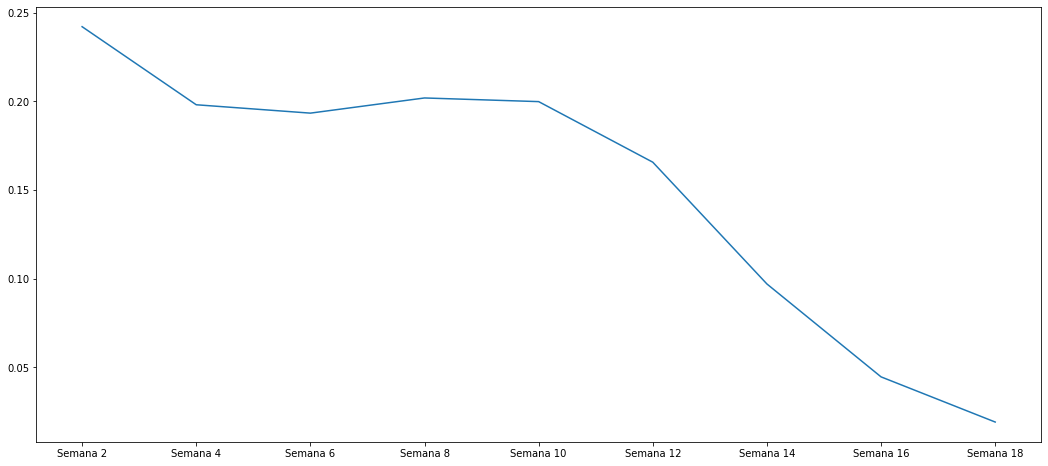

In [15]:
pd.set_option('display.max_columns', None)
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
pd.concat(erroresTotales1).describe()
pd.concat(erroresTotales1).describe().iloc[1,:].plot()

In [16]:
pd.concat(erroresTotales1).describe()

,Semana 2,Semana 4,Semana 6,Semana 8,Semana 10,Semana 12,Semana 14,Semana 16,Semana 18
count,60.000000,60.000000,60.000000,60.000000,58.000000,44.000000,30.000000,16.000000,2.000000
mean,0.242028,0.198036,0.193319,0.201865,0.199807,0.165674,0.097060,0.044708,0.019262
std,0.268894,0.147390,0.114250,0.096960,0.124558,0.129017,0.079480,0.028375,0.001668
min,0.017642,0.016126,0.021980,0.026565,0.027118,0.016949,0.015728,0.016882,0.018082
25%,0.053507,0.052887,0.094072,0.118312,0.103682,0.063695,0.035857,0.022850,0.018672
50%,0.123186,0.184687,0.195730,0.195353,0.154225,0.099399,0.072819,0.035029,0.019262
75%,0.369506,0.344345,0.284344,0.268255,0.319469,0.297045,0.156954,0.058326,0.019851
max,1.040393,0.434519,0.407439,0.379044,0.415121,0.383836,0.263315,0.109962,0.020441


In [17]:
pd.concat(erroresTotales2).describe()


,Semana 2,Semana 4,Semana 6,Semana 8,Semana 10,Semana 12,Semana 14,Semana 16,Semana 18
count,60.000000,60.000000,60.000000,60.000000,58.000000,44.000000,30.000000,16.000000,2.000000
mean,0.372496,0.306851,0.246537,0.215722,0.186012,0.139122,0.068187,0.025353,0.015352
std,0.619235,0.335382,0.250809,0.210072,0.173403,0.129805,0.056228,0.010441,0.001057
min,0.001733,0.011955,0.010224,0.005180,0.003845,0.002484,0.012458,0.013439,0.014604
25%,0.012622,0.016567,0.061492,0.065878,0.049823,0.040694,0.025320,0.018696,0.014978
50%,0.026336,0.203987,0.141371,0.088422,0.071053,0.051811,0.038679,0.024067,0.015352
75%,0.455616,0.504022,0.334987,0.327343,0.370782,0.265385,0.118186,0.027431,0.015725
max,2.837590,1.154030,0.848202,0.652797,0.542349,0.369733,0.203755,0.053539,0.016099


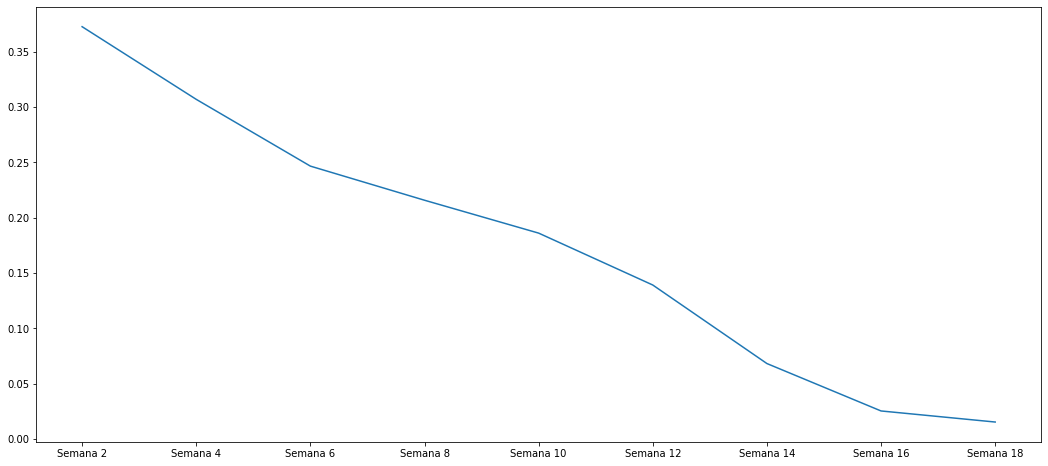

In [18]:
pd.concat(erroresTotales2).describe().iloc[1,:].plot()

In [130]:
erroresTotales1, erroresTotales2 = bucleErrores(df_train[["Inbps"]],df_train[["Outbps"]],[.75])
#



C:\Users\Alejandro\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [134]:
pd.set_option('display.max_columns', None)
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
pd.concat(erroresTotales1).describe()
pd.concat(erroresTotales1).describe().iloc[1,:].plot()

,Semana 2,Semana 4,Semana 6,Semana 8,Semana 10,Semana 12,Semana 14,Semana 16,Semana 18
count,60.000000,60.000000,60.000000,60.000000,58.000000,44.000000,30.000000,16.000000,2.000000
mean,0.123299,0.070429,0.048055,0.049603,0.049001,0.029336,0.012223,0.008704,0.010460
std,0.156654,0.077088,0.039967,0.037282,0.040346,0.019743,0.006273,0.002241,0.000413
min,0.002137,0.001714,0.002337,0.004772,0.004061,0.003510,0.002802,0.005837,0.010168
25%,0.012892,0.011378,0.009626,0.021452,0.021729,0.020812,0.005774,0.007170,0.010314
50%,0.042107,0.041884,0.043037,0.041822,0.041701,0.025668,0.013167,0.007917,0.010460
75%,0.201721,0.096206,0.075133,0.063144,0.057521,0.031814,0.017097,0.010087,0.010606
max,0.631970,0.308494,0.157803,0.148342,0.159586,0.090607,0.021964,0.012518,0.010752


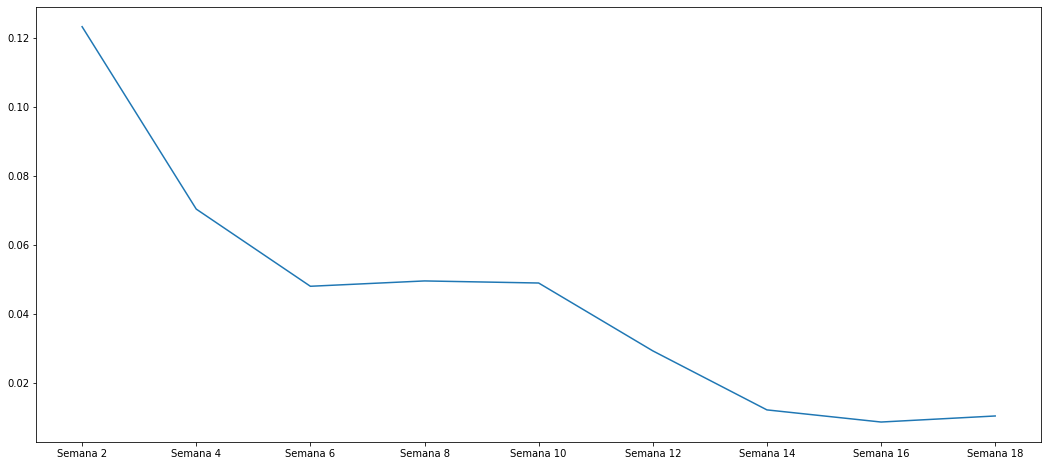

In [135]:
pd.concat(erroresTotales1).describe().iloc[1,:].plot()

In [137]:
pd.concat(erroresTotales2).describe()

,Semana 2,Semana 4,Semana 6,Semana 8,Semana 10,Semana 12,Semana 14,Semana 16,Semana 18
count,60.000000,60.000000,60.000000,60.000000,58.000000,44.000000,30.000000,16.000000,2.000000
mean,0.007120,0.005097,0.004306,0.004207,0.003668,0.001371,0.000642,0.000561,0.000731
std,0.009729,0.005442,0.005226,0.005312,0.004839,0.000889,0.000297,0.000147,0.000043
min,0.000301,0.000298,0.000328,0.000321,0.000310,0.000295,0.000260,0.000399,0.000701
25%,0.001141,0.000944,0.000879,0.001486,0.001264,0.000795,0.000388,0.000461,0.000716
50%,0.002684,0.003457,0.002882,0.002054,0.001594,0.001124,0.000625,0.000506,0.000731
75%,0.009612,0.006140,0.004664,0.004679,0.004740,0.001571,0.000802,0.000655,0.000746
max,0.040763,0.023804,0.022054,0.021791,0.022056,0.003691,0.001313,0.000878,0.000762


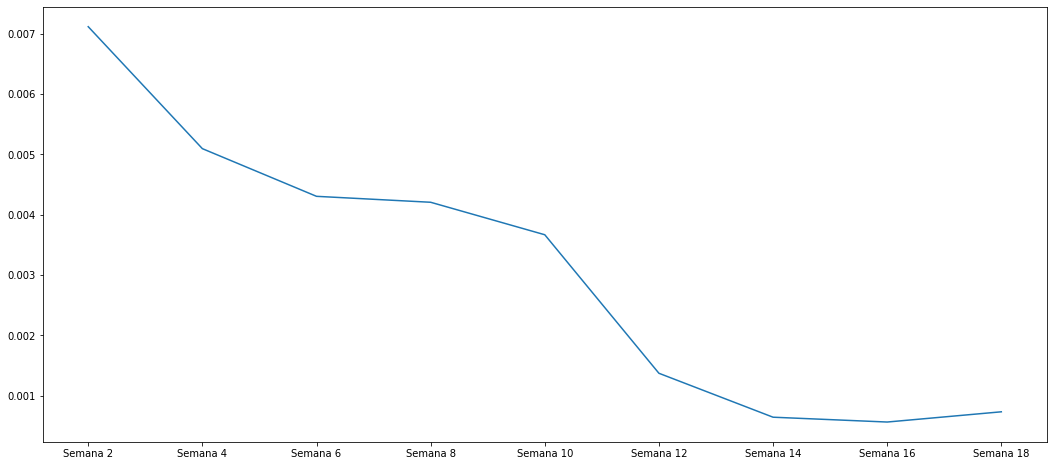

In [136]:
pd.concat(erroresTotales2).describe().iloc[1,:].plot()

In [138]:
erroresTotales1, erroresTotales2 = bucleErrores(df_train[["Inbps"]],df_train[["Outbps"]],[.5])

C:\Users\Alejandro\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [139]:
pd.concat(erroresTotales1).describe()

,Semana 2,Semana 4,Semana 6,Semana 8,Semana 10,Semana 12,Semana 14,Semana 16,Semana 18
count,60.000000,60.000000,60.000000,60.000000,58.000000,44.000000,30.000000,16.000000,2.000000
mean,0.022824,0.017904,0.016469,0.016847,0.015275,0.009609,0.004677,0.003991,0.004874
std,0.023480,0.015370,0.011630,0.009201,0.009078,0.004823,0.002479,0.000695,0.000276
min,0.000918,0.001006,0.001227,0.001902,0.001388,0.001387,0.001267,0.002977,0.004678
25%,0.004278,0.003582,0.004072,0.010093,0.009374,0.007269,0.002245,0.003399,0.004776
50%,0.014543,0.014365,0.016844,0.016978,0.014662,0.010009,0.004944,0.003892,0.004874
75%,0.030020,0.029798,0.025381,0.022367,0.018275,0.011205,0.006447,0.004796,0.004971
max,0.086596,0.056435,0.039111,0.037655,0.037117,0.021025,0.008692,0.004956,0.005069


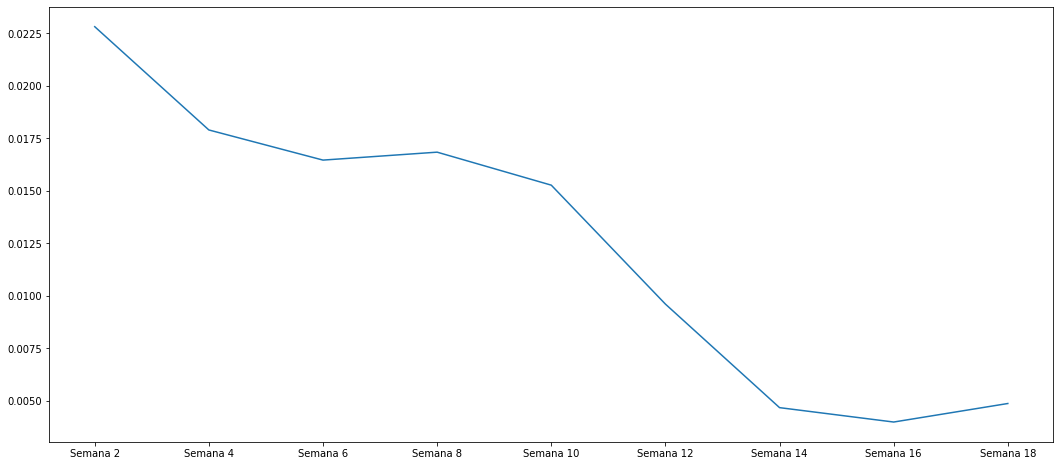

In [140]:
pd.concat(erroresTotales1).describe().iloc[1,:].plot()

In [141]:
pd.concat(erroresTotales2).describe()

,Semana 2,Semana 4,Semana 6,Semana 8,Semana 10,Semana 12,Semana 14,Semana 16,Semana 18
count,60.000000,60.000000,60.000000,60.000000,58.000000,44.000000,30.000000,16.000000,2.000000
mean,0.000787,0.000571,0.000466,0.000416,0.000424,0.000161,0.000104,0.000103,0.000130
std,0.001599,0.001443,0.001445,0.001433,0.001459,0.000062,0.000037,0.000016,0.000004
min,0.000054,0.000061,0.000073,0.000064,0.000063,0.000068,0.000059,0.000079,0.000127
25%,0.000197,0.000144,0.000131,0.000161,0.000150,0.000137,0.000073,0.000091,0.000129
50%,0.000435,0.000310,0.000200,0.000206,0.000213,0.000156,0.000099,0.000101,0.000130
75%,0.000876,0.000619,0.000386,0.000259,0.000257,0.000187,0.000124,0.000114,0.000132
max,0.012176,0.011325,0.011338,0.011252,0.011257,0.000394,0.000182,0.000131,0.000134


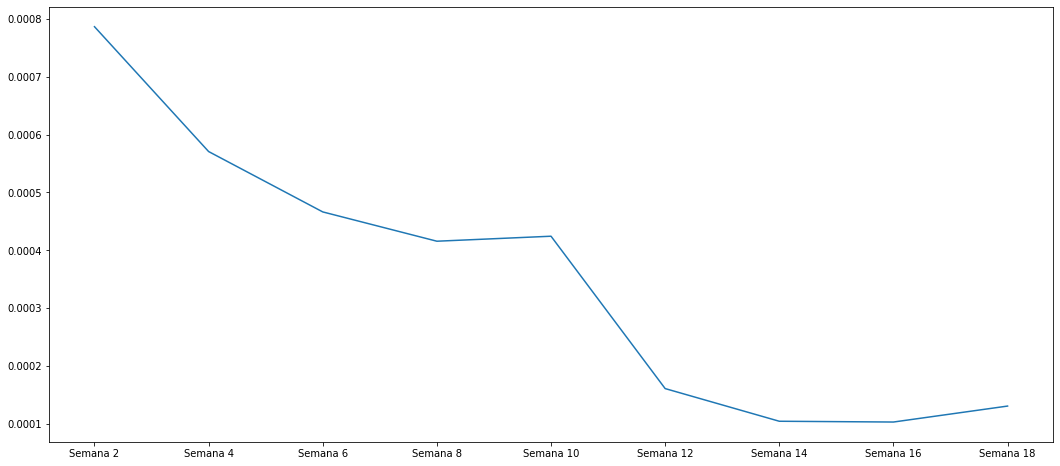

In [142]:
pd.concat(erroresTotales2).describe().iloc[1,:].plot()

In [143]:
erroresTotales1, erroresTotales2 = bucleErrores(df_train[["Inbps"]],df_train[["Outbps"]],[.25])

C:\Users\Alejandro\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [144]:
pd.concat(erroresTotales1).describe()

,Semana 2,Semana 4,Semana 6,Semana 8,Semana 10,Semana 12,Semana 14,Semana 16,Semana 18
count,60.000000,60.000000,60.000000,60.000000,58.000000,44.000000,30.000000,16.000000,2.000000
mean,0.009599,0.008253,0.007445,0.007344,0.006214,0.003771,0.002124,0.001998,0.002419
std,0.010222,0.007378,0.004965,0.004022,0.003629,0.002010,0.001112,0.000267,0.000171
min,0.000392,0.000404,0.000501,0.000709,0.000632,0.000548,0.000534,0.001613,0.002298
25%,0.000955,0.001540,0.002164,0.004638,0.003607,0.002301,0.001038,0.001801,0.002359
50%,0.006031,0.006374,0.007350,0.007564,0.006301,0.004029,0.002231,0.001939,0.002419
75%,0.014719,0.012332,0.011362,0.009238,0.007670,0.004983,0.002954,0.002207,0.002480
max,0.037666,0.024916,0.017535,0.016519,0.014358,0.008043,0.003944,0.002487,0.002541


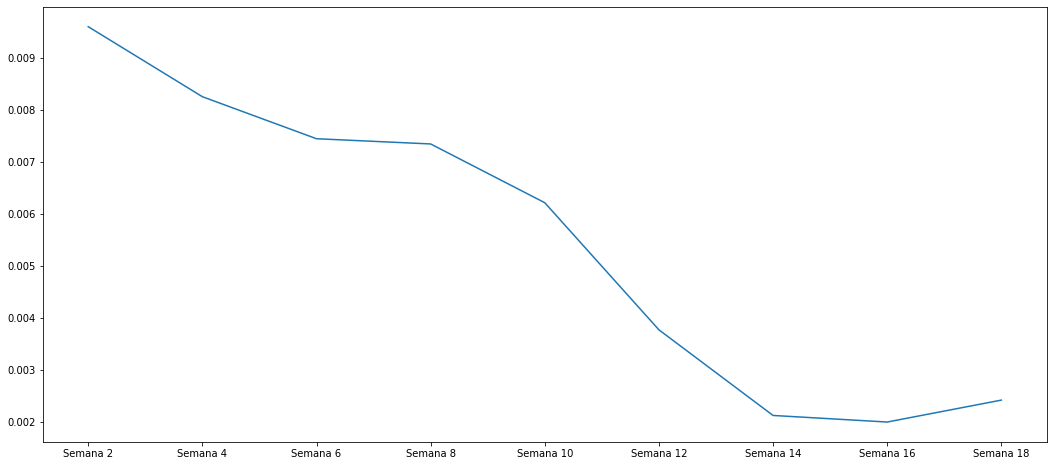

In [145]:
pd.concat(erroresTotales1).describe().iloc[1,:].plot()

In [146]:
pd.concat(erroresTotales2).describe()

,Semana 2,Semana 4,Semana 6,Semana 8,Semana 10,Semana 12,Semana 14,Semana 16,Semana 18
count,60.000000,60.000000,60.000000,60.000000,58.000000,44.000000,30.000000,16.000000,2.000000
mean,0.000263,0.000185,0.000157,0.000133,0.000122,0.000102,0.000081,0.000080,0.000088
std,0.000240,0.000153,0.000139,0.000073,0.000055,0.000042,0.000027,0.000013,0.000003
min,0.000031,0.000033,0.000037,0.000038,0.000037,0.000036,0.000035,0.000063,0.000086
25%,0.000072,0.000067,0.000049,0.000071,0.000074,0.000061,0.000054,0.000071,0.000087
50%,0.000182,0.000129,0.000101,0.000109,0.000121,0.000101,0.000086,0.000077,0.000088
75%,0.000380,0.000281,0.000203,0.000209,0.000171,0.000135,0.000103,0.000086,0.000090
max,0.001131,0.000511,0.000521,0.000275,0.000214,0.000188,0.000125,0.000113,0.000091


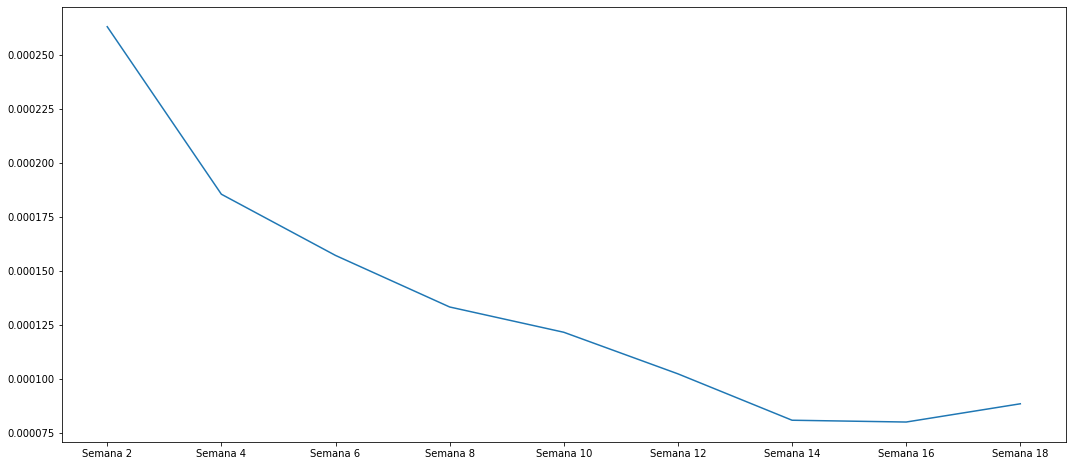

In [147]:
pd.concat(erroresTotales2).describe().iloc[1,:].plot()